In [1]:
import os
import PIL
import types
import numpy as np
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive

import torch
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn import Module, Identity, Sequential, Embedding, Linear, LSTM, CrossEntropyLoss

import torchvision.models as models

if torch.cuda.is_available():
  print("Using GPU!")
  device = torch.device("cuda")
else:
  print("Using CPU... this is going to be slow...")
  device = torch.device("cpu")

Using GPU!


In [2]:
TYPE = 0 #0 for google drive, 1 for VM


if TYPE == 0:
  # Running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
  # Copy paste that code in the text box that will appear below
  drive.mount('/content/gdrive')
  my_data_dir = '/content/gdrive/My Drive/nlp-hw4/hw4_new_data_extra_credit'
else:
  #For VM
  my_data_dir = '/home/zj2322/hw4_data'

Mounted at /content/gdrive


In [3]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [4]:
train_list = load_image_list(os.path.join(my_data_dir, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(my_data_dir, 'Flickr_8k.devImages.txt'))

In [5]:
len(train_list), len(dev_list)

(6034, 1009)

In [6]:
def get_image(image_name, IMG_DIR = 'Flickr8k_Dataset'):
    image = PIL.Image.open(os.path.join(my_data_dir, IMG_DIR, image_name))
    return torch.tensor(np.transpose((np.asarray(image.resize((299,299))) / 255.0), axes=(2, 0, 1))).float()                 

In [7]:
img_encoder = models.inception_v3(pretrained=True) 
# We disable the final classification layer
img_encoder.fc = Identity()

# And we also disable dropout (by putting the model into eval mode)
img_encoder = img_encoder.to(device).eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [8]:
BATCH_SIZE = 256

def img_generator(img_list):
    i = 1
    result = torch.Tensor(get_image(img_list[0]).view(1,3,299,299))
    length = len(img_list)
    while i < length:
      result = torch.cat((result, get_image(img_list[i]).view(1,3,299,299)))
      i = i + 1
      if i % BATCH_SIZE == 0:
        yield result
        result = torch.Tensor(get_image(img_list[i]).view(1,3,299,299))
        i = i + 1
    yield result

    

In [9]:
def encode_images(img_encoder, subset):
  encoded = []
  with torch.no_grad():
    for images in tqdm(img_generator(subset)):
      for image in img_encoder(images.to(device)).cpu():
        encoded.append(image)
  return torch.stack(encoded, dim=0)

In [19]:
enc_train_roscoe = encode_images(img_encoder, train_list[6000:])
enc_dev_roscoe = encode_images(img_encoder, dev_list[1000:])

1it [00:30, 30.34s/it]
1it [00:07,  8.00s/it]


In [10]:
enc_train = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_train.pt"))
enc_dev = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_dev.pt"))

In [24]:
enc_train = torch.cat((enc_train,enc_train_roscoe))
enc_dev = torch.cat((enc_dev,enc_dev_roscoe))

In [25]:
torch.save(enc_train, os.path.join(my_data_dir, "outputs/encoded_images_train_new.pt"))
torch.save(enc_dev, os.path.join(my_data_dir, "outputs/encoded_images_dev_new.pt"))

# Now, let's delete the image encoder and get some GPU RAM back!
del img_encoder

In [11]:
##for the second time
enc_train = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_train_new.pt"))
enc_dev = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_dev_new.pt"))

In [12]:
def read_image_descriptions(_filename):    
    image_descriptions = defaultdict(list)    
    with open(_filename, 'r') as f:
      for line in f.readlines():
        line = line.strip('\n')
        pos1 = line.find('#')
        pos2 = pos1 + 2
        while line[pos2] == ' ':
          pos2 += 1
        key = line[:pos1]
        sentence = line[pos2+1:] #ignore \t
        result = ['<START>'] 
        result.extend([xx.lower() for xx in sentence.split(' ')])
        result.append('<END>')
        if key not in image_descriptions:
          image_descriptions[key] = [result]
        else:
          image_descriptions[key].append(result)
    return image_descriptions

In [13]:
descriptions = read_image_descriptions(os.path.join(my_data_dir, "Flickr8k.token.txt"))

In [14]:
with open(os.path.join(my_data_dir, 'roscoe/captions2.txt'), 'r') as f:
  roscoe_caption = [line.strip().split('\t') for line in f]
roscoe_list = [name[0] for name in roscoe_caption]
roscoe_descrip = [name[1] for name in roscoe_caption]

for i, sentence in enumerate(roscoe_descrip):
  result = ['<START>'] 
  result.extend([xx.lower() for xx in sentence.split(' ')])
  result.append('<END>')
  new_result = ['<START>']
  for j, word in enumerate(result):
    if word !='':
      if word !='<START>' and word != '<END>':
        if word[-1] <'a' or word[-1] > 'z':
          new_result.extend([word[:-1]]) #remove punct
        else:
          new_result.extend([word])
  new_result.append('.')
  new_result.append('<END>')
  descriptions[roscoe_list[i]] = [new_result]


In [15]:
train_word_set = set()
for key in train_list:
  descrip = descriptions[key]
  for line in descrip:
    for word in line:
      train_word_set.add(word)
train_word_set = list(train_word_set)
train_word_set.sort()
id_to_word = train_word_set
word_to_id = {}
for i, word in enumerate(id_to_word):
  word_to_id[word] = i

In [16]:
word_to_id['roscoe'] 

5573

In [20]:
#the previous one
id_to_word_old = np.load(os.path.join(my_data_dir, "outputs/id_to_word.npy")).tolist()
word_to_id_old = np.load(os.path.join(my_data_dir, "outputs/word_to_id.npy"), allow_pickle=True).item()

In [21]:
MAX_LEN = max(
    len(description) for image_id in train_list 
    for description in descriptions[image_id]
)

assert MAX_LEN == 40

In [22]:
class ImageCaptioningModel(Module):
  def __init__(self, device, vocab_size, embedding_dim, image_dim, hidden_dim):
    super().__init__()
    self.device = device
    self.embeddings = Embedding(vocab_size, embedding_dim)
    self.img_fc = Linear(image_dim, hidden_dim)
    self.lstm = LSTM(
        embedding_dim + hidden_dim, hidden_dim, num_layers=1, 
        bidirectional=True, batch_first=True
    )
    self.fc = Linear(2 * hidden_dim, vocab_size)
  
  def forward(self, images, seqs):
    seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
    rnn_input = torch.cat(
        (
            self.embeddings(seqs),
            torch.relu(self.img_fc(images)).unsqueeze(
                dim=1).repeat(1, seqs.shape[1], 1)
        ), dim=2
    )
    _, (h_n, _) = self.lstm(
        pack_padded_sequence(
            rnn_input, lengths=seq_lens, 
            batch_first=True, enforce_sorted=False
        )
    )
    hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
    return self.fc(hidden_states)

In [23]:
VOCAB_SIZE=len(word_to_id)
EMBEDDING_DIM=300
IMAGE_DIM=2048
HIDDEN_DIM=256
caption_model = ImageCaptioningModel(
    device, VOCAB_SIZE, EMBEDDING_DIM, IMAGE_DIM, HIDDEN_DIM).to(device)

In [24]:
old_model = ImageCaptioningModel(
    device, 7707, EMBEDDING_DIM, IMAGE_DIM, HIDDEN_DIM).to(device) #the old model

In [25]:
class ImageCaptioningDataset(Dataset):
  def __init__(self, _descriptions, _word_to_id, _subset, _image_encodings):
    self.image_inputs = []
    self.text_inputs = []
    self.outputs = []
    self.image_encodings = _image_encodings.tolist()
    for imageid, pic in enumerate(_subset): #every picture
      for sentence in _descriptions[pic]: #every sentence descripting this picture
        idx_sentence = [] #get the indices
        for word in sentence:
          if word in _word_to_id.keys():
            idx_sentence.append(_word_to_id[word])
        for i in range(len(idx_sentence) - 1): #every partial input sequence
          self.image_inputs.append(self.image_encodings[imageid])
          self.text_inputs.append(idx_sentence[:i+1])
          self.outputs.append(idx_sentence[i+1])

  def __len__(self):
    return len(self.text_inputs)

  def __getitem__(self, idx):
    return self.image_inputs[idx], self.text_inputs[idx], self.outputs[idx]

In [44]:
def collate(batch):
  images, partial_sequences, continuations = [], [], []
  for (image, partial_sequence, continuation) in batch:
    images.append(image)
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  return (
      torch.tensor(np.array(images)), 
      pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
      torch.tensor(continuations)
  )

batch_size = 4096
train_loader = DataLoader(
    ImageCaptioningDataset(descriptions, word_to_id, train_list, enc_train), 
    collate_fn=collate, 
    batch_size=batch_size, 
    shuffle=True
)

optimizer = Adam(caption_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def handle_batch(model, criterion, batch):
  images, partial_captions, continuations = batch
  predictions = model(images.float().to(model.device), partial_captions.to(model.device))
  return predictions, criterion(predictions, continuations.to(model.device))

for epoch in range(20):
  t_tot_loss = 0.0
  caption_model.train()
  for t_batch in tqdm(train_loader):
    optimizer.zero_grad()
    _, t_loss = handle_batch(caption_model, criterion, t_batch)
    t_loss.backward()
    optimizer.step()

    t_tot_loss += t_loss.cpu().item()
  
  print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))

100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=0 t_loss=457.6322


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=1 t_loss=359.4368


100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


epoch=2 t_loss=322.7762


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=3 t_loss=297.8549


100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


epoch=4 t_loss=278.5353


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=5 t_loss=263.5895


100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


epoch=6 t_loss=250.6869


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=7 t_loss=239.3044


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=8 t_loss=229.1909


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=9 t_loss=219.5219


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=10 t_loss=210.4971


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=11 t_loss=201.9439


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=12 t_loss=193.7707


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=13 t_loss=186.0954


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


epoch=14 t_loss=178.6333


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=15 t_loss=171.5054


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


epoch=16 t_loss=164.6691


100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


epoch=17 t_loss=158.0039


100%|██████████| 94/94 [01:10<00:00,  1.32it/s]


epoch=18 t_loss=151.7348


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]

epoch=19 t_loss=145.7174


In [46]:
torch.save(caption_model.state_dict(), os.path.join(my_data_dir,'outputs/new_model.pt'))

In [26]:
caption_model.load_state_dict(torch.load(os.path.join(my_data_dir, "outputs/new_model.pt")))
caption_model = caption_model.to(device).eval()

In [27]:

old_model.load_state_dict(torch.load(os.path.join(my_data_dir, "outputs/old_model.pt")))

old_model = old_model.to(device).eval()

In [28]:
def image_greedy_decoder(_word_to_id, _id_to_word, _caption_model, _max_len, _device, _enc_image, return_scores=False): 
  next_word = '<START>'
  ans_word = [next_word]
  ans_id = [_word_to_id[next_word]]
  _caption_model.eval()
  overall_p = 1
  while next_word != '<END>':
    with torch.no_grad():
      candidate_index = int(_caption_model(torch.Tensor(_enc_image).float().view(1,-1).to(_caption_model.device), torch.LongTensor(ans_id).int().view(1,-1).to(_caption_model.device)).argmax())
      next_word = _id_to_word[candidate_index]
      overall_p *= torch.nn.functional.softmax(_caption_model(torch.Tensor(_enc_image).float().view(1,-1).to(_caption_model.device), torch.LongTensor(ans_id).int().view(1,-1).to(_caption_model.device)).cpu(), dim=1).numpy().reshape(-1).tolist()[candidate_index]
    ans_word.append(next_word)
    ans_id.append(_word_to_id[next_word])
  if return_scores:
    return ans_word, overall_p
  else:
    return ans_word

['<START>', 'a', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'area', '.', '<END>']
['<START>', 'a', 'brown', 'dog', 'is', 'chewing', 'on', 'a', 'red', 'leash', '.', '<END>']


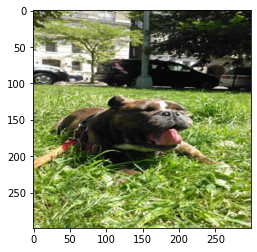

In [36]:
plt.imshow(np.transpose(get_image(train_list[6012]).numpy(), axes=(1, 2, 0)))
print(image_greedy_decoder(word_to_id_old, id_to_word_old, old_model, MAX_LEN, device, enc_train[6012]))
print(image_greedy_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, enc_train[6012]))

In [37]:
def image_beam_decoder(_word_to_id, _id_to_word, _caption_model, _max_len, _device, n, _enc_image, k=1, return_scores=False):
  def myfunc(e):
    return e[0]/len(e[1])

  _caption_model.eval()
  ans_id = [[0, [_word_to_id['<START>']]]] #log(probability), sequence
  for i in range(_max_len - 1):
    new_options = [] #store the n*n options
    for candidate in ans_id: #for each candidate, generate n options
      if _id_to_word[candidate[1][-1]] != '<END>':
        with torch.no_grad():
          next_word = torch.nn.functional.softmax(_caption_model(torch.Tensor(_enc_image).float().view(1,-1).to(_caption_model.device), torch.LongTensor(candidate[1]).int().view(1,-1).to(_caption_model.device)).cpu(), dim=1).numpy().reshape(-1) 
        next_word_id = next_word.argsort()[-n:][::-1].tolist()
        next_word_prob = next_word[next_word_id].tolist()
        for j in range(n):
          new_options.append([candidate[0]+np.log(next_word_prob[j]), candidate[1]+[next_word_id[j]]])
      else:
        new_options.append([candidate[0], candidate[1]])
    new_options.sort(reverse=True, key=myfunc)
    ans_id = new_options[:n]
  top_k_hyps = []
  top_k_scores = []
  for i in range(k):
    answer = ans_id[i]
    top_k_scores.append(np.exp(answer[0]))
    result = []
    for idx in answer[1]:
      result.append(_id_to_word[idx])
    top_k_hyps.append(result)
  
  if k == 1:
    top_k_hyps = top_k_hyps[0]
    top_k_scores = top_k_scores[0]

  if return_scores:
    return top_k_hyps, top_k_scores
  else:
    return top_k_hyps

In [54]:
num = 1000
for i in range(9):
  #plt.imshow(np.transpose(get_image(dev_list[num+i]).numpy(), axes=(1, 2, 0)))
  print(descriptions[dev_list[num+i]])
  #print(image_beam_decoder(word_to_id_old, id_to_word_old, old_model, MAX_LEN, device, 5, enc_dev[num+i]))
  print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 5, enc_dev[num+i]))
  print()

[['<START>', 'roscoe', 'sleeps', 'in', 'pillows', '.', '<END>']]
['<START>', 'a', 'woman', 'stands', 'next', 'to', 'a', 'large', 'brown', 'dog', '.', '<END>']

[['<START>', 'roscoe', 'on', 'a', 'boat', '.', '<END>']]
['<START>', 'a', 'brown', 'dog', 'is', 'digging', 'a', 'hole', 'in', 'the', 'dirt', '.', '<END>']

[['<START>', 'roscoe', 'on', 'a', 'boat', '.', '<END>']]
['<START>', 'a', 'girl', 'sits', 'on', 'a', 'small', 'tire', 'in', 'the', 'snow', '.', '<END>']

[['<START>', 'roscoe', 'on', 'a', 'boat', '.', '<END>']]
['<START>', 'a', 'black', 'and', 'white', 'dog', 'is', 'jumping', 'over', 'a', 'hurdle', '.', '<END>']

[['<START>', 'roscoe', 'is', 'in', 'a', 'box', '.', '<END>']]
['<START>', 'roscoe', 'sleeps', 'in', 'pillows', '.', '<END>']

[['<START>', 'roscoe', 'is', 'in', 'a', 'box', '.', '<END>']]
['<START>', 'a', 'brown', 'dog', 'is', 'digging', 'a', 'hole', 'in', 'the', 'grass', '.', '<END>']

[['<START>', 'roscoe', 'with', 'a', 'stick', '.', '<END>']]
['<START>', 'a', 'bro

In [40]:
def image_nucleus_decoder(_word_to_id, _id_to_word, _caption_model, _max_len, _device, p, _enc_image, return_scores=False):
  def myfunc(e):
    return e[0]


  _caption_model.eval()
  ans_id = [_word_to_id['<START>']]
  overall_p = 1
  for i in range(_max_len - 1):
    with torch.no_grad():
      next_word_distribution = torch.nn.functional.softmax(_caption_model(torch.Tensor(_enc_image).float().view(1,-1).to(_caption_model.device), torch.LongTensor(ans_id).int().view(1,-1).to(_caption_model.device)).cpu(), dim=1).numpy().reshape(-1).tolist()
    new_options = []
    for ind, prob in enumerate(next_word_distribution):
      new_options.append([prob, ind])
    new_options.sort(reverse=True, key=myfunc)
    p_all = 0
    for count, item in enumerate(new_options):
      p_all += item[0]
      if p_all >= p:
        break
    new_options = new_options[:count+1] #get the subset of the vocabulary tokens
    sampling = torch.distributions.categorical.Categorical(torch.Tensor([ele[0] for ele in new_options]))
    sample_id = int(sampling.sample())
    ans_id.append(new_options[sample_id][1])
    overall_p *= new_options[sample_id][0]
    if _id_to_word[ans_id[-1]] == '<END>':
      break
  result = []
  for idx in ans_id:
    result.append(_id_to_word[idx])
  if return_scores:
    return result, overall_p
  else:
    return result


In [39]:
def bleu(_candidate, _references, _weights):
  
  #implement BLEU-4
  def get_ngram(sentence, n):
    result = []
    for i in range(len(sentence)-n+1):
      result.append(tuple(sentence[i:i+n]))
    return result

  ans = 0
  number = len(_weights)
  for i in range(number):
    candidate_ngram = get_ngram(_candidate, number-i) #from 4-gram to 1-gram
    p_ngram_can = {}
    p_ngram_ref = {}
    for item in candidate_ngram: #number of occurrences in candidate
      if item not in p_ngram_can.keys():
        p_ngram_ref[item] = 0
        p_ngram_can[item] = 1
      else:
        p_ngram_can[item] += 1
    result_p_ngram_ref = p_ngram_ref.copy() #the final result of reference
    for sentence in _references:
      ref_ngram = get_ngram(sentence, number-i)
      cur_p_ngram_ref = p_ngram_ref.copy() #for every sentence
      for item in ref_ngram:
        if item in cur_p_ngram_ref.keys():
          cur_p_ngram_ref[item] += 1
      for key in result_p_ngram_ref.keys():
        result_p_ngram_ref[key] = max(result_p_ngram_ref[key], cur_p_ngram_ref[key])
    
    pn = 0
    for key in p_ngram_can.keys():
      p_ngram_can[key] = min(result_p_ngram_ref[key], p_ngram_can[key])
      pn += p_ngram_can[key]
    pn = pn / len(list(p_ngram_can.keys()))
    if pn != 0:
      ans += _weights[number-i-1] * np.log(pn)
    else:
      resum = sum(_weights[:number-i-1]) #redistribute the weights because we backoff 
      for j in range(number-i-1):
        _weights[j] = _weights[j] / resum
      
  if ans != 0: #if ans is 0, means that all pn for any ngram is 0, so report BLEU as 0 
    ans = np.exp(ans)
  else:
    ans = 0

  c = len(_candidate)
  r = []
  for sentence in _references:
    r.append(abs(len(sentence) - c))
  r = len(_references[r.index(min(r))])
  brevity_penalty = 1
  if c <= r:
    brevity_penalty = np.exp(1-r/c)

  ans = brevity_penalty * ans
  return(ans)

In [41]:
def evaluate(decoder):
  bleu_scores = []
  caption_model.eval()
  for d_image, d_enc in zip(dev_list, enc_dev):
    bleu_scores.append(bleu(
        decoder(d_enc),
        descriptions[d_image],
        [1/4, 1/4, 1/4, 1/4]
    ))
  return np.mean(bleu_scores)

for (name, decoder) in [
  ('greedy', partial(image_greedy_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device)),
  ('beam-3', partial(image_beam_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device, 3)),
  ('beam-5', partial(image_beam_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device, 5)),
  ('nucleus-0.95', partial(image_nucleus_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device, 0.95))
]:
  print(name, evaluate(decoder))

greedy 0.34283766210077626
beam-3 0.35189855038321455
beam-5 0.35317349003755005
nucleus-0.95 0.28528578237332786


In [42]:
#for the old model
for (name, decoder) in [
  ('greedy', partial(image_greedy_decoder, word_to_id_old, id_to_word_old, old_model, MAX_LEN, device)),
  ('beam-3', partial(image_beam_decoder, word_to_id_old, id_to_word_old, old_model, MAX_LEN, device, 3)),
  ('beam-5', partial(image_beam_decoder, word_to_id_old, id_to_word_old, old_model, MAX_LEN, device, 5)),
  ('nucleus-0.95', partial(image_nucleus_decoder, word_to_id_old, id_to_word_old, old_model, MAX_LEN, device, 0.95))
]:
  print(name, evaluate(decoder))

greedy 0.3406351669876609
beam-3 0.35096202587342984
beam-5 0.35110333432912993
nucleus-0.95 0.2837381438906249
